# Active Learning Notebook

Use the large data set with active learning.

## Notes 04-27-2022

Did some debugging. The linear model works right now. The GP model is not working currently so have asked Berkay if there are parameters that give some good values. Random runs throught the `multiple_rounds` function, but the accuracy is extremely high at the very start 0.94. This is with 30 training samples. I'm wondering if the data is somehow sorted so that the first 1000 samples that I'm currently using for testing are similar and hence the high accuracy even with only 30 sample for training. Next step is to pre-shuffle the data and see if this makes the early stages of the random have a lower accuracy. 

TODO:

 - [x] pre-shuffle the data (as you recently did in the pace visualization repository).
 - [x] try and get the GPR model working
 - [ ] examine efficiency
   - [ ] do the fit for the PCA only with the training data (not the pooled data)
 - [ ] batch jobs. don't relearn so frequently
 - [ ] parallel
 
 Integerate into ModAL
 
 - [ ] Figure out how to cache the greedy sampling distances and labeled and unlabeled samples
   - [ ] should that data be returned from the query with an updated model. 
   - is there an expectation that the model is updated after the query???
 

In [1]:
import numpy as np
import dask.array as da
from dask_ml.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from dask_ml.decomposition import IncrementalPCA
from dask_ml.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
#from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

from pymks import (
    generate_multiphase,
    plot_microstructures,
    PrimitiveTransformer,
    TwoPointCorrelation,
    GenericTransformer,
    solve_fe
)

from toolz.curried import curry, pipe, valmap, itemmap, iterate, do, merge_with
from toolz.curried import map as map_
from modAL.models import ActiveLearner, CommitteeRegressor, BayesianOptimizer
from modAL.disagreement import max_std_sampling
from modAL.models import BayesianOptimizer
from modAL.acquisition import max_EI
import tqdm
import types
from pymks.fmks.func import sequence
from active import gsx_query, gsy_query, igs_query, multiple_rounds, three_way_split, flatten

import dask.array as da

from itertools import cycle

## Load the data

In [2]:
data = np.load('data_shuffled.npz')

In [3]:
x_data = data['x_data']
y_data = data['y_data'].reshape(-1)

In [4]:
print(x_data.shape)
print(y_data.shape)

(8900, 132651)
(8900,)


## Functions to generate models

Here we use the GPR model as it returns a probability that's required by the `ActiveLearner` class.

In [5]:
def pca_steps():
    return (
        ("reshape", GenericTransformer(
            lambda x: x.reshape(x.shape[0], 51, 51,51)
        )),    
        ("discritize",PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
        ("correlations",TwoPointCorrelation(periodic_boundary=True, cutoff=20, correlations=[(0, 0)])),
        ('flatten', GenericTransformer(lambda x: x.reshape(x.shape[0], -1))),
        ('pca', IncrementalPCA(n_components=3)),
    )

In [6]:
def make_gp_model():
    kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5)) + WhiteKernel(noise_level=0.1)
    regressor = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=99)
    return Pipeline(steps=pca_steps() + (
        ('regressor', regressor),
    ))

def make_linear_model():
    return Pipeline(steps=pca_steps() + (
        ('poly', PolynomialFeatures(degree=3)),
        ('regressor', LinearRegression()),
    ))

def pca_model():
    return Pipeline(steps=pca_steps())

## The Oracle

The oracle function is an FE simulation on the 2D grid.

In [7]:
@curry 
def oracle_func(x_data, y_data, query_instance):
    idx, query_value = query_instance
    return query_value.reshape(1, -1), np.array([y_data[idx]]).reshape(1)

## Helper Functions

In [8]:
def plot_parity(y_test, y_predict, label='Testing Data'):
    pred_data = np.array([y_test, y_predict])
    line = np.min(pred_data), np.max(pred_data)
    plt.plot(pred_data[0], pred_data[1], 'o', label=label)
    plt.plot(line, line, '-', linewidth=3, color='k')
    plt.title('Goodness of Fit', fontsize=20)
    plt.xlabel('Actual', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    plt.legend(loc=2, fontsize=15)
    return plt

## Set up the active learners

One is a GPR using the maximum std and the other is random

In [52]:
from active import make_igs, make_gsx, make_gsy, make_bayes, make_uncertainty, make_ensemble, make_random, make_active

distance_transformer = lambda x: pca_model().fit_transform(x)

#def query_uncertainty(model, x_pool):
#    if not hasattr(model, 'batch_ids') or len(model.batch_ids) == 0:
#        uncertainties = model.predict(x_pool, return_std=True)[1]
#        args = np.argsort(uncertainties)[::-1]
#        model.batch_ids = args[:5]
#    next_item = (model.batch_ids[0], x_pool[model.batch_ids[0]])
#    model.batch_ids = model.batch_ids[1:]
#    print('next id', next_item[0])
#    return next_item

query_uncertainty = lambda model, x_: pipe(
    model.predict(x_, return_std=True)[1],
    np.argmax,
    lambda i: (i, x_[i]), 
    do(lambda x: print('id:', x[0]))
)

def make_learners(x_train, y_train):
    return dict(
        uncertainty=make_active(query_uncertainty)(make_gp_model, x_train, y_train),
#        random=make_random(make_gp_model, x_train, y_train),
#        ensemble=make_ensemble(x_train, y_train),
#        bayes=make_bayes(make_gp_model, x_train, y_train),
#        gsx=make_gsx(distance_transformer)(make_linear_model, x_train, y_train),
#        gsy=make_gsy(make_linear_model, x_train, y_train),
#        igs=make_igs(distance_transformer)(make_linear_model, x_train, y_train)
    )

#random_learner = make_random(make_gp_model, x_train, y_train)

## Check the data

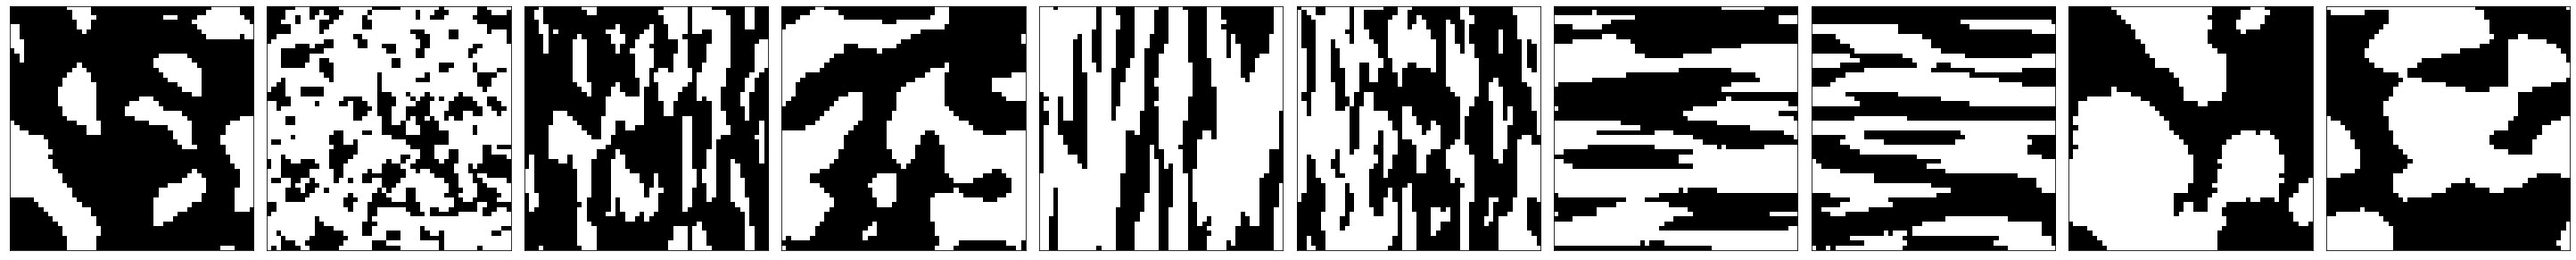

In [10]:
plot_microstructures(*x_data[:10].reshape(10, 51, 51, 51)[:, :, :, 0], cmap='gray', colorbar=False);

In [48]:
n_use = 2000
props = (0.93, 0.05)

x_pool, x_test, x_train, y_pool, y_test, y_train, indices_pool, indices_test, indices_train = three_way_split(x_data[:n_use], y_data[:n_use], props, None)

In [49]:
print(indices_train)

[1523  698  881 1059 1640  999  884 1292  829 1228  588  625  184 1753
  960 1392 1732 1065  187  910 1665 1417 1427  664   40 1996 1070 1154
  127 1520 1163 1290  576 1478  687  179  110  681 1139    6]


In [50]:
print(x_pool.shape)
print(x_test.shape)
print(x_train.shape)

(1860, 132651)
(100, 132651)
(40, 132651)


In [51]:
print(y_pool.shape)
print(y_test.shape)
print(y_train.shape)

(1860,)
(100,)
(40,)


## Test the model

In [44]:
def evaluate_model(x_data, y_data, model_func, train_ids, test_ids):
    model = model_func()
    x_train, y_train = x_data[train_ids], y_data[train_ids]
    x_test, y_test = x_data[test_ids], y_data[test_ids]
    model.fit(x_train, y_train)
    stds = model.predict(x_data, return_std=True)[1]
    ids = np.argsort(stds)[::-1][:5]
    print('train_score:', model.score(x_train, y_train))
    print('test_score:', model.score(x_test, y_test))
    return ids 

In [24]:
model = make_gp_model()
#model = make_linear_model()

In [ ]:
model.fit(x_pool, y_pool)

In [52]:
%%timeit
y_pool_predict = model.predict(x_pool)

29.4 s ± 222 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
%%timeit
y_pool_predict = model.predict(x_pool)

29.3 s ± 2.31 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
y_pool_predict = model.predict(x_pool)

In [35]:
y_test_predict = model.predict(x_test)

<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

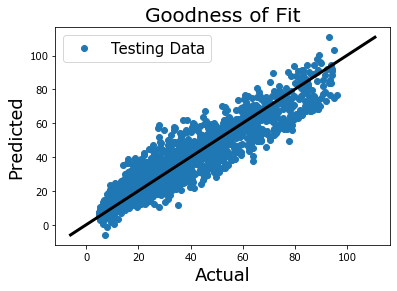

In [36]:
plot_parity(y_pool, y_pool_predict)

<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

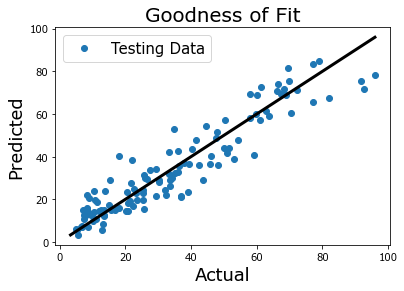

In [37]:
plot_parity(y_test, y_test_predict)

In [38]:
from sklearn.metrics import r2_score

print(r2_score(y_test, y_test_predict))
#print(y_test.shape)
#print(y_test)
print(model.score(x_test, y_test))

0.8768196402010203
0.8768196402010203


## Debug

In [47]:
train_ids = [ 858,  304,  583,  385, 1407, 1486, 1544, 1054,  752,  171, 1753, 1277,  436,  996, 945, 1680, 1401,  721, 1162, 1357]
test_ids = [ 718, 1857,  651, 1129, 1404, 1027, 1659,  809, 1103,  146, 1049,  232, 1572, 1916,
  1602, 1703, 1088,  500,  419,  202,  819, 1599, 1008,  885,  132, 1451,  259, 1039,
  1973, 1202, 1393,  618,  253, 1236,    2,  865, 1203, 1821,  248,  174,  168,  917,
   86,  614, 1331, 1568, 1846,  561, 1736, 1004,  115, 1814,  407,  640, 1330,  832,
  758,    9, 1530, 1435, 1214,  976, 1726,  111,  433, 1580, 1414,  218, 1494,  333,
  1864,  208,  137,  962,    6, 1124,  152,  817,  317, 1906, 1750,  851, 1732, 1364,
  947,  780,  580,   16, 1849,   26,  261, 1320, 1898,  689, 1892,  797, 1389, 1501,
  1253,  390, 1621,  494, 1293, 1624, 1211, 1775,  442, 1927,  382,  937, 1791, 1862,
  778,  396, 1487,  828,  217,  538, 1613,  982]

next_id = evaluate_model(x_data[:n_use], y_data[:n_use], make_gp_model, train_ids, test_ids)
print('next_id:', next_id)
train_ids.append(120)
next_id = evaluate_model(x_data[:n_use], y_data[:n_use], make_gp_model, train_ids, test_ids)
print('next_id:', next_id)
train_ids.append(1875)
next_id = evaluate_model(x_data[:n_use], y_data[:n_use], make_gp_model, train_ids, test_ids)
print('next_id:', next_id)
#train_ids.append(3)
#next_id = evaluate_model(x_data[:n_use], y_data[:n_use], make_gp_model, train_ids, test_ids)
#print('next_id:', next_id)
#train_ids.append(4)
#next_id = evaluate_model(x_data[:n_use], y_data[:n_use], make_gp_model, train_ids, test_ids)
#print('next_id:', next_id)

train_score: 0.4699154232882711
test_score: 0.5902260906711574
next_id: [ 120 1875 1775 1186  267]
train_score: -0.0007695273987911033
test_score: -0.01877049361967953
next_id: [ 120 1875 1775 1186  267]
train_score: 0.5196815554116142
test_score: 0.5928617657061204
next_id: [ 120 1875 1775 1186  267]


## Run the learners (linear model)

In [55]:
scores = multiple_rounds(x_data[:n_use], y_data[:n_use], 1, 10, make_learners, oracle_func, props, 99)

indices_test [ 819 1599 1008  885  132 1451  259 1039 1973 1202 1393  618  253 1236
    2  865 1203 1821  248  174  168  917   86  614 1331 1568 1846  561
 1736 1004  115 1814  407  640 1330  832  758    9 1530 1435 1214  976
 1726  111  433 1580 1414  218 1494  333 1864  208  137  962    6 1124
  152  817  317 1906 1750  851 1732 1364  947  780  580   16 1849   26
  261 1320 1898  689 1892  797 1389 1501 1253  390 1621  494 1293 1624
 1211 1775  442 1927  382  937 1791 1862  778  396 1487  828  217  538
 1613  982]
indices_train [ 858  304  583  385 1407 1486 1544 1054  752  171 1753 1277  436  996
  945 1680 1401  721 1162 1357  718 1857  651 1129 1404 1027 1659  809
 1103  146 1049  232 1572 1916 1602 1703 1088  500  419  202]
evaluating uncertainty


  0%|          | 0/10 [00:00<?, ?it/s]

id: 1418


 20%|██        | 2/10 [00:31<02:05, 15.63s/it]

id: 1418


 30%|███       | 3/10 [01:03<02:36, 22.38s/it]

id: 1418


 40%|████      | 4/10 [01:34<02:35, 25.83s/it]

id: 1003


 50%|█████     | 5/10 [02:06<02:19, 27.85s/it]

id: 1003


 60%|██████    | 6/10 [02:37<01:56, 29.05s/it]

id: 1418


 70%|███████   | 7/10 [03:09<01:29, 29.96s/it]

id: 390


 80%|████████  | 8/10 [03:41<01:01, 30.55s/it]

id: 1843


 90%|█████████ | 9/10 [04:13<00:31, 31.04s/it]

id: 1843


100%|██████████| 10/10 [04:45<00:00, 28.54s/it]


id: 249


In [56]:
scores

{'uncertainty': (array([0.69022424, 0.69069451, 0.68949404, 0.69059673, 0.68954549,
         0.69010374, 0.69010383, 0.6902142 , 0.69120078, 0.69187337,
         0.69042281]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))}

In [36]:
scores

{'uncertainty': (array([ 0.59022609, -0.01877049,  0.59294937,  0.59790351,  0.60286141,
          0.60569658,  0.67809997,  0.68295184,  0.70942162,  0.70959422,
          0.7138594 ,  0.71401167,  0.71430548,  0.71426049,  0.71370606,
          0.71288992,  0.71412582,  0.71501959,  0.7148975 ,  0.71488728,
          0.71632833,  0.71633639,  0.71732312,  0.71696442,  0.71844737,
          0.71858516,  0.70571966, -2.43700011, -2.43700011, -2.43700011,
         -2.43700011, -2.43700011, -2.43700011, -2.43700011, -2.43700011,
         -2.43700011, -2.43700011, -2.43700011, -2.43700011, -2.43700011,
         -2.43700011, -2.43700011, -2.43700011, -2.43700011, -2.43700011,
         -2.43700011, -2.43700011, -2.43700011, -2.43700011, -2.43700011,
         -2.43700011, -2.43700011, -2.43700011, -2.43700011,  0.6812977 ,
         -2.43700011,  0.70612252, -2.43700011,  0.70035231,  0.69768228,
          0.70451072, -2.43700011, -2.43700011, -2.43700011, -2.43700011,
         -2.43700011, -

(0.0, 1.0)

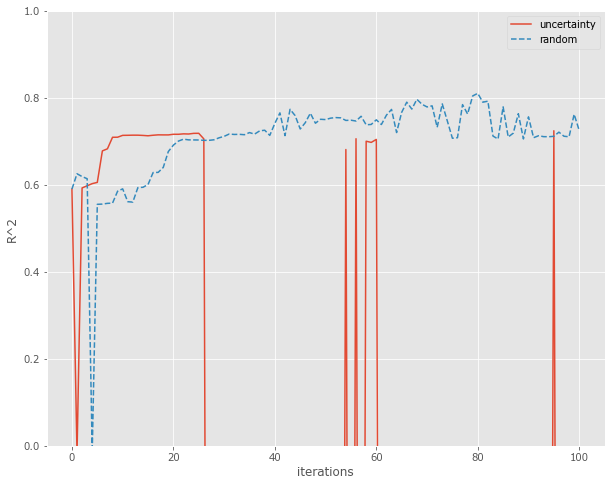

In [37]:
lines = ["-","--","-.",":"]
linecycler = cycle(lines)

plt.style.use('ggplot')
plt.figure(figsize=(10, 8))
ax = plt.gca()

for k, v in scores.items():
    y = v[0]
    e = v[1]
    x = np.arange(len(y))
    ax.plot(x, y, label=k, linestyle=next(linecycler))
    if k in ['std', 'bayes', 'gsx', 'gsy', 'igs']:
        ax.fill_between(x, y - e, y + e, alpha=0.1)
plt.legend()
plt.xlabel('iterations')
plt.ylabel('R^2');
plt.ylim(0, 1)

## Run the learners (GP model)

In [14]:
scores = multiple_rounds(x_data[:n_use], y_data[:n_use], 1, 20, make_learners, oracle_func, props, 99)

evaluating uncertainty


100%|██████████| 20/20 [05:16<00:00, 15.80s/it]


evaluating random


100%|██████████| 20/20 [01:26<00:00,  4.33s/it]


evaluating bayes


100%|██████████| 20/20 [05:28<00:00, 16.41s/it]


evaluating gsx


100%|██████████| 20/20 [05:37<00:00, 16.88s/it]


evaluating gsy


100%|██████████| 20/20 [05:26<00:00, 16.34s/it]


evaluating igs


100%|██████████| 20/20 [09:38<00:00, 28.90s/it]


In [15]:
scores


{'uncertainty': (array([ 0.56338491,  0.56261501,  0.56241542,  0.6089452 ,  0.62341315,
          0.62559374, -2.30585858, -2.30587505, -2.30587362, -2.30587505,
          0.75620825, -2.30587505,  0.42593145,  0.33812503,  0.31843733,
          0.62564616,  0.30494424,  0.24395588, -2.30410289,  0.35292066,
         -0.34776795]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.])),
 'random': (array([0.56338491, 0.57827383, 0.58187398, 0.59401296, 0.59397805,
         0.61836939, 0.62941761, 0.63709403, 0.64032037, 0.74286012,
         0.75542221, 0.75728636, 0.73888593, 0.7123319 , 0.74985073,
         0.76956591, 0.63018141, 0.76431861, 0.78778076, 0.77083507,
         0.7544838 ]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.])),
 'bayes': (array([ 0.56338491, -0.00659136,  0.62108636,  0.75476722,  0.68497973,
          0.68324156, -2.30587505, -2.30587505,  0.71791255, -2


## The results

(0.0, 1.0)

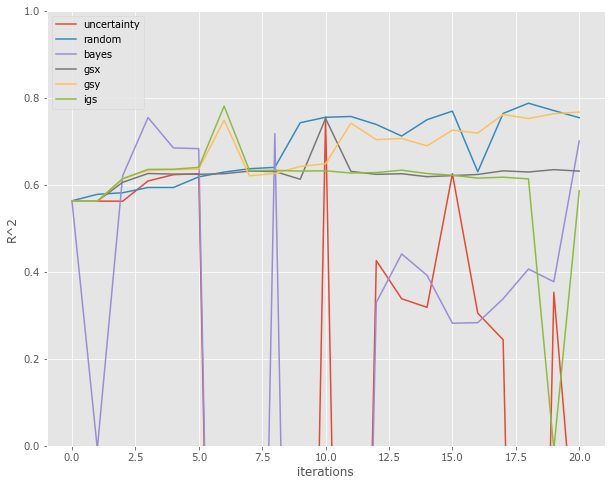

In [16]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 8))
ax = plt.gca()

for k, v in scores.items():
    y = v[0]
    e = v[1]
    x = np.arange(len(y))
    ax.plot(x, y, label=k)
    if k in ['std', 'bayes', 'gsx', 'gsy', 'igs']:
        ax.fill_between(x, y - e, y + e, alpha=0.1)
plt.legend()
plt.xlabel('iterations')
plt.ylabel('R^2');
plt.ylim(0, 1)

(0.9, 1.0)

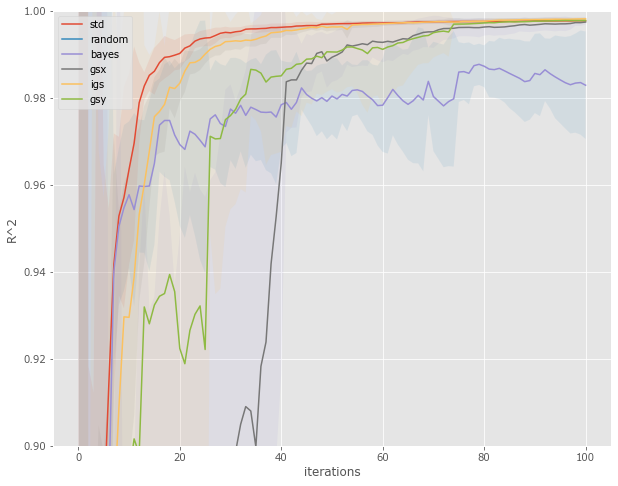

In [99]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 8))
ax = plt.gca()

for k, v in scores.items():
    y = v[0]
    e = v[1]
    x = np.arange(len(y))
    ax.plot(x, y, label=k)
    if k in ['std', 'bayes', 'gsx', 'gsy', 'igs']:
        ax.fill_between(x, y - e, y + e, alpha=0.1)
plt.legend()
plt.xlabel('iterations')
plt.ylabel('R^2');
plt.ylim(0.9, 1)

## Check what the accuracy actually looks like

In [79]:
y_pred_std = learner_accuracy['std'][1].predict(x_test)
y_pred_random = learner_accuracy['random'][1].predict(x_test)

<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

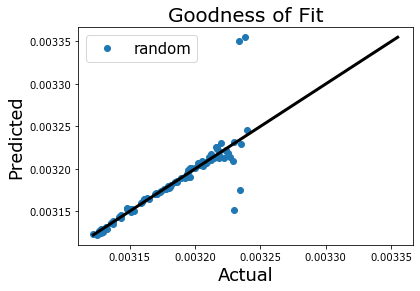

In [89]:
plot_parity(y_test, y_pred_random, label='random')

<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

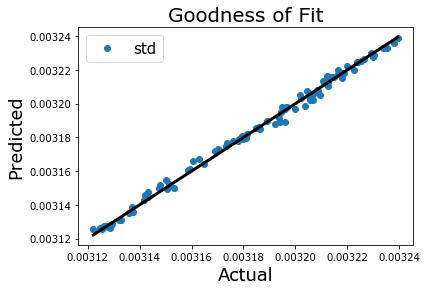

In [90]:
plot_parity(y_test, y_pred_std, label='std')